# skorch doctor

Use tips from Andrej Karpathy on how to better understand the neural net and diagnose potential errors.

Sources:

- https://karpathy.github.io/2019/04/25/recipe/
- https://www.youtube.com/watch?v=P6sfmUTpUmc
    
The `SkorchDoctor` class tries to automate as much as possible from those tips.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from skorch.helper import SkorchDoctor

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [3]:
plt.style.use('seaborn')

## New code

### A toy binary classification task

We load a toy classification task from `sklearn`.

In [4]:
X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X, y = X.astype(np.float32), y.astype(np.int64)

In [5]:
X.shape, y.shape, y.mean()

((1000, 20), (1000,), 0.5)

### Definition of the `pytorch` classification `module`

In [6]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(20, self.num_units)
        self.nonlin = self.nonlin
        self.dropout = nn.Dropout(self.dropout)
        self.dense1 = nn.Linear(self.num_units, self.num_units)
        self.output = nn.Linear(self.num_units, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [7]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=5,
    lr=0.1,
    batch_size=64,
)

## Use skorch doctor

### Train the doctor first

It's sufficient to use a small amount of data

In [8]:
doctor = SkorchDoctor(net)

In [9]:
doctor.fit(X[:100], y[:100])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6913       0.6000        0.6635  0.0101
      2        0.6642       0.5500        0.6603  0.0055
      3        0.6834       0.6000        0.6589  0.0067
      4        0.6783       0.7000        0.6556  0.0064
      5        0.6499       0.6500        0.6588  0.0073


## Inspect data

### names of modules, layers, and parameters

For convenience, a few attributes are provided to discover all the modules, layers, and parameter names of the net. Note that by default, skorch sets the `module` and the `criterion` attribute.

In [10]:
doctor.module_names_

['module', 'criterion']

In [11]:
doctor.layer_names_

{'module': ['', 'dense0', 'dropout', 'dense1', 'output'], 'criterion': ['']}

In [12]:
doctor.param_names_

{'module': ['dense0.weight',
  'dense0.bias',
  'dense1.weight',
  'dense1.bias',
  'output.weight',
  'output.bias'],
 'criterion': []}

### logs

For each epoch and each batch, the activations, gradients, and parameter updates of each module are stored. The dictionary thus has the following structure:

    {
        module_name:
            [for each epoch
                [for each batch
                    {layer_name/param_name: value}
                ]
            ]
        for each module
    }
    
The names of the attributes are:

1. `doctor.activation_logs_`: the activations of each layer for each module
2. `doctor.gradient_logs_`: the gradients of each parameter for each module
3. `doctor.param_update_logs_`: the standard deviation of updates relative to the standard deviation of the parameter for each module

#### Example: plot activations of `dense0` and the gradients of its weights

In [13]:
module = 'module'
layer_name = 'dense0'
param_name = 'dense0.weight'
epoch = -1  # last epoch
batch = 0  # first batch
activations = doctor.activation_logs_[module][epoch][batch][layer_name]
gradients = doctor.gradient_logs_[module][epoch][batch][param_name]

In [14]:
print(activations.shape)  # shape is (batch size, number of output units)
print(gradients.shape)  # shape is the shape of the weights

(64, 10)
(10, 20)


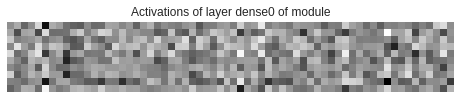

In [15]:
plt.imshow(activations.T)
plt.title(f"Activations of layer {layer_name} of {module}")
plt.xticks([])
plt.yticks([])
plt.grid(None)

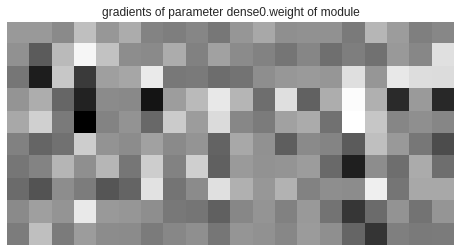

In [16]:
plt.imshow(gradients)
plt.title(f"gradients of parameter {param_name} of {module}")
plt.xticks([])
plt.yticks([])
plt.grid(None)

#### Example: stats of each layer

Example: Get the mean absolute activation of each layer in the last batch of the first epoch.

In [17]:
for key, val in doctor.activation_logs_['module'][0][-1].items():
    print(f"activation of layer {key:<9}: min{val.min():>8.4f}, mean abs{np.abs(val).mean():>7.4f}, max{val.max():>7.4f}")

activation of layer dense0   : min -4.5384, mean abs 0.9948, max 3.4531
activation of layer dropout  : min  0.0000, mean abs 0.5156, max 6.6446
activation of layer dense1   : min -2.2393, mean abs 0.5101, max 2.5080
activation of layer output   : min -0.1363, mean abs 0.1840, max 1.3120


#### Example: stats for each parameter

Example: Get the mean absolute gradient of each parameter from the first batch of the second epoch.

In [18]:
for key, val in doctor.gradient_logs_['module'][1][0].items():
    print(f"activation of layer {key:<14}: min{val.min():>8.4f}, mean abs{np.abs(val).mean():>7.4f}, max{val.max():>7.4f}")

activation of layer output.bias   : min -0.0753, mean abs 0.0753, max 0.0753
activation of layer output.weight : min -0.0577, mean abs 0.0212, max 0.0577
activation of layer dense1.bias   : min -0.0333, mean abs 0.0128, max 0.0218
activation of layer dense1.weight : min -0.0429, mean abs 0.0093, max 0.0283
activation of layer dense0.bias   : min -0.0184, mean abs 0.0066, max 0.0239
activation of layer dense0.weight : min -0.0723, mean abs 0.0082, max 0.0458


## Plots

### Plot train and validation loss

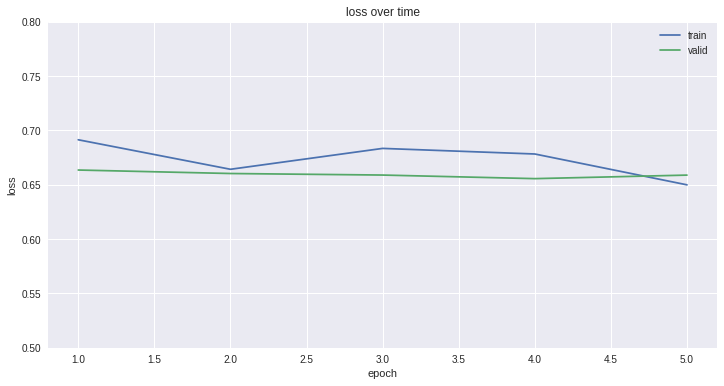

In [19]:
_, ax = plt.subplots(figsize=(12, 6))
doctor.plot_loss(ax=ax)
ax.set_ylim([0.5, 0.8]);

### Plot distribution of activations of each layer

#### first step

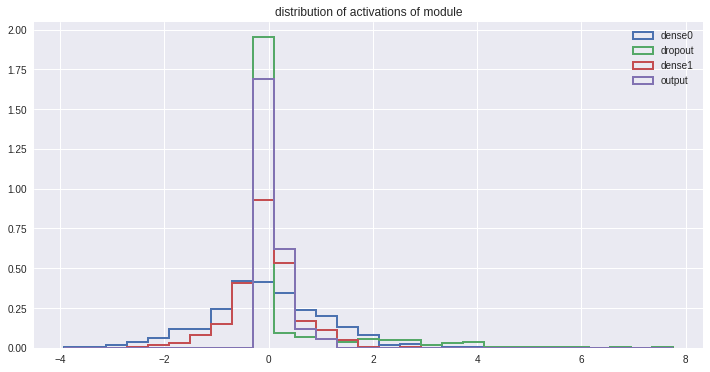

In [20]:
doctor.plot_activations(step=0);

#### last step (default)

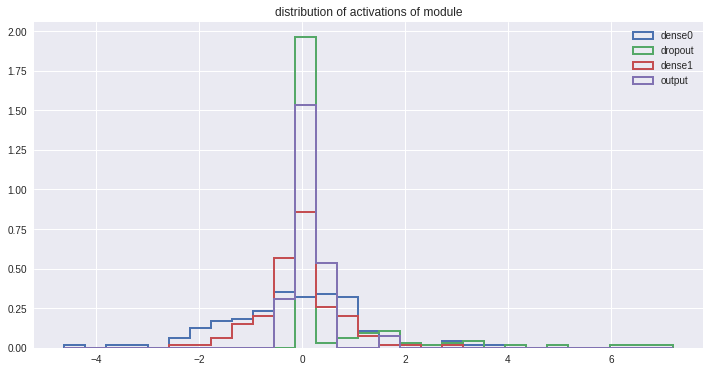

In [21]:
_, axes = plt.subplots(figsize=(12, 6), squeeze=False)
doctor.plot_activations(axes=axes);

### Show gradients of each parameter

#### first step

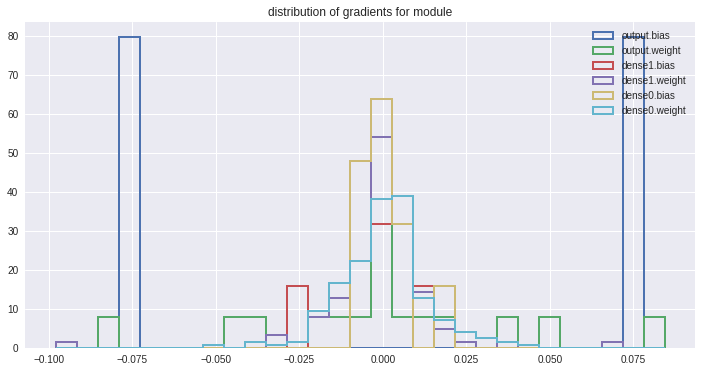

In [22]:
doctor.plot_gradients(step=0);

#### last step (default)

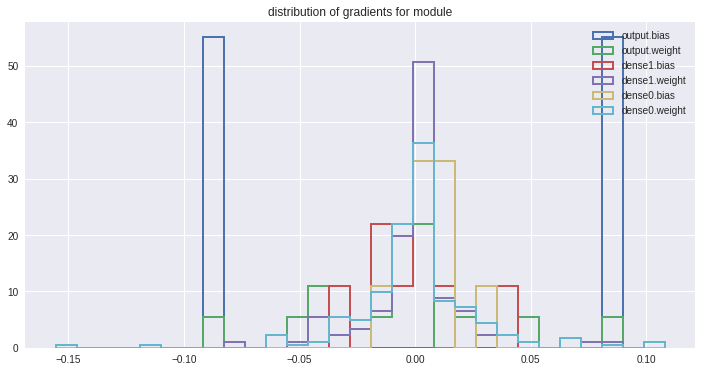

In [23]:
_, axes = plt.subplots(figsize=(12, 6), squeeze=False)
doctor.plot_gradients(axes=axes, step=-1);

### Plots over time

#### Show parameter updates over time

See https://youtu.be/P6sfmUTpUmc?t=5995

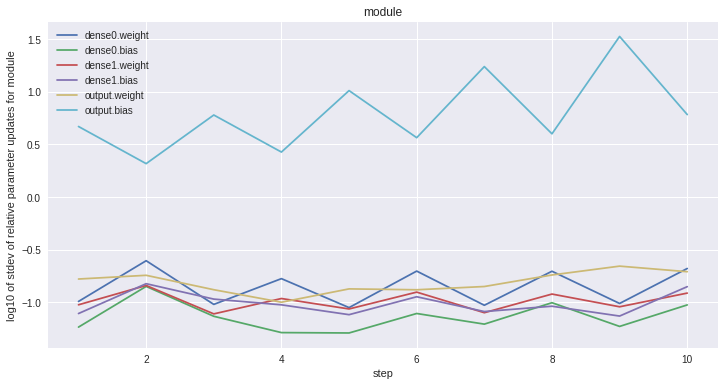

In [24]:
doctor.plot_param_updates();

#### activations over time

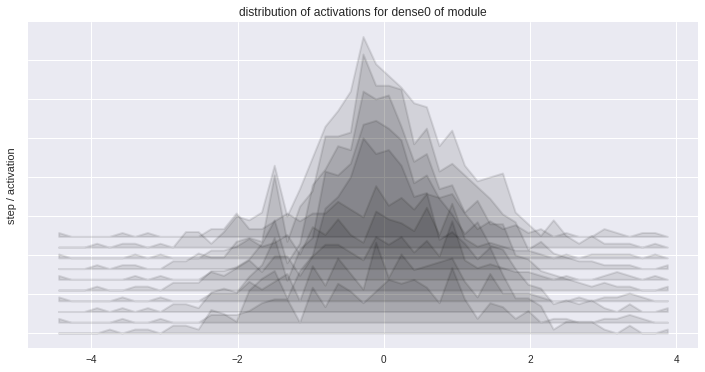

In [25]:
doctor.plot_activations_over_time('dense0');

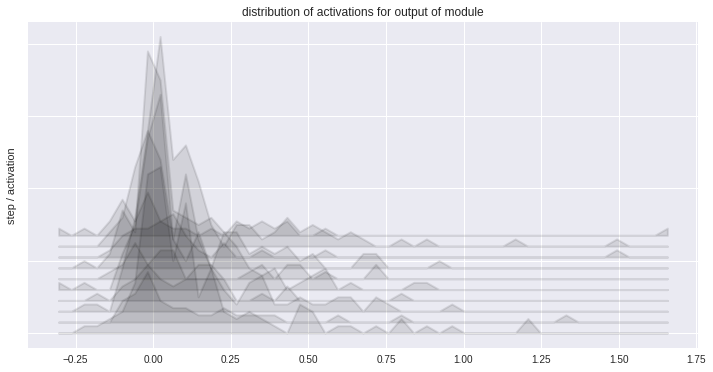

In [26]:
doctor.plot_activations_over_time('output');

#### gradients over time

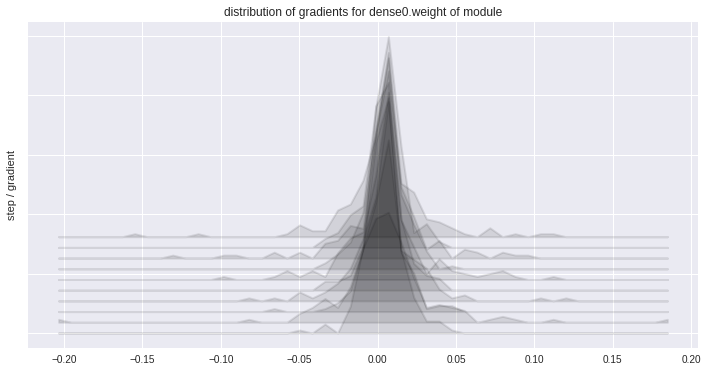

In [27]:
doctor.plot_gradient_over_time("dense0.weight");

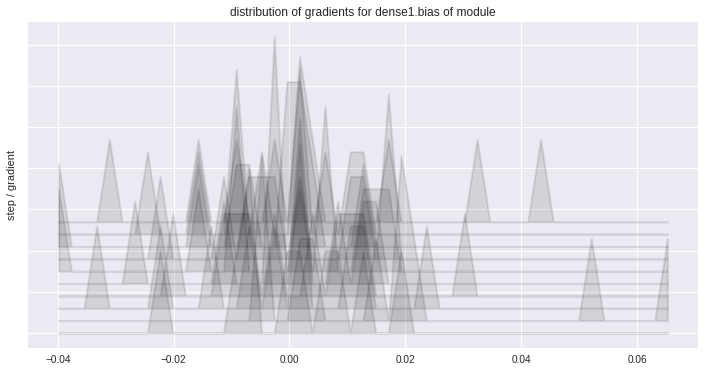

In [28]:
doctor.plot_gradient_over_time("dense1.bias");